In [1]:
pose_3d = "/workspace/data/unity_data/RecordingsPose/male_pose3d.jsonl"
pose_2d_left = "/workspace/data/unity_data/RecordingsPose/cam_left camera/male_kpt2d_left camera.jsonl"
pose_2d_right = "/workspace/data/unity_data/RecordingsPose/cam_right camera/male_kpt2d_right camera.jsonl"
left_video = "/workspace/data/unity_data/Recordings/left.mp4"
right_video = "/workspace/data/unity_data/Recordings/right.mp4"

In [2]:
# 删除最初的两针，用来和video进行对齐
import json

def trim_first_two_frames(input_path, output_path):
    trimmed_data = []
    
    # 1. 读取数据 (包含BOM处理)
    with open(input_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

    # 2. 跳过最初的2行，从第3行（索引2）开始处理
    # 同时将 frame_idx 从0重新计数
    new_frame_idx = 0
    for line in lines[2:-1]:
        if not line.strip():
            continue
            
        data = json.loads(line)
        # 重置帧编号（如有必要）
        if 'frame_idx' in data:
            data['frame_idx'] = new_frame_idx
        elif 'frame' in data:
            data['frame'] = new_frame_idx 
            
        trimmed_data.append(data)
        new_frame_idx += 1

    # 3. 保存为新文件
    with open(output_path, 'w', encoding='utf-8') as f:
        for entry in trimmed_data:
            f.write(json.dumps(entry) + '\n')

    print(f"完成: 删除了最初的2帧，保存了{len(trimmed_data)}帧。")
    return trimmed_data

# 执行
for i in (pose_3d, pose_2d_left, pose_2d_right):
    input_file = i
    output_file = i.replace('.jsonl', '_trimmed.jsonl')
    trim_first_two_frames(input_file, output_file)

完成: 删除了最初的2帧，保存了677帧。
完成: 删除了最初的2帧，保存了677帧。
完成: 删除了最初的2帧，保存了677帧。


In [3]:
pose_3d = "/workspace/data/unity_data/RecordingsPose/male_pose3d_trimmed.jsonl"
pose_2d_left = "/workspace/data/unity_data/RecordingsPose/cam_left camera/male_kpt2d_left camera_trimmed.jsonl"
pose_2d_right = "/workspace/data/unity_data/RecordingsPose/cam_right camera/male_kpt2d_right camera_trimmed.jsonl"

In [4]:
import json

def analyze_pose_data(json_file_path):
    all_joints = set()
    frame_count = 0
    
    # 統計計算用の辞書
    stats = {}

    with open(json_file_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            if not line.strip():
                continue
            
            frame_data = json.loads(line)
            frame_count += 1
            
            for joint in frame_data['joints3d']:
                name = joint['name']
                all_joints.add(name)
                
                # 初めて登場する関節の初期化
                if name not in stats:
                    stats[name] = {'min_y': float('inf'), 'max_y': float('-inf'), 
                                   'min_x': float('inf'), 'max_x': float('-inf')}
                
                # Y座標（高さ）などの範囲を更新
                stats[name]['min_y'] = min(stats[name]['min_y'], joint['y'])
                stats[name]['max_y'] = max(stats[name]['max_y'], joint['y'])
                stats[name]['min_x'] = min(stats[name]['min_x'], joint['x'])
                stats[name]['max_x'] = max(stats[name]['max_x'], joint['x'])

    print(f"--- データの概要 ---")
    print(f"総フレーム数: {frame_count}")
    print(f"関節の総数: {len(all_joints)}")
    print(f"\n--- 主要な関節の高さ(Y)の可動範囲 ---")
    
    # 主要な関節をピックアップして表示
    targets = ['Pelvis', 'head', 'Foot_L', 'Hand_L']
    for t in targets:
        if t in stats:
            s = stats[t]
            print(f"{t:10}: {s['min_y']:.3f}m ~ {s['max_y']:.3f}m")

    print("\n--- 全関節リスト ---")
    print(", ".join(sorted(list(all_joints))))

# 実行
analyze_pose_data(pose_3d)

--- データの概要 ---
総フレーム数: 677
関節の総数: 91

--- 主要な関節の高さ(Y)の可動範囲 ---
Pelvis    : 0.065m ~ 0.990m
head      : 0.187m ~ 1.632m
Foot_L    : -0.107m ~ 0.386m
Hand_L    : 0.043m ~ 2.027m

--- 全関節リスト ---
Bone_Eye_L, Bone_Eye_R, Bone_Eyebrow_C, Bone_Eyebrow_L, Bone_Eyebrow_R, Bone_Eyelid_Lower_L, Bone_Eyelid_Lower_R, Bone_Eyelid_Upper_L, Bone_Eyelid_Upper_R, Bone_Jaw, Bone_Lip_L, Bone_Lip_R, Bone_Ski_Goggles_01_L, Bone_Ski_Goggles_01_R, Bone_Ski_Goggles_02_L, Bone_Ski_Goggles_02_R, Bone_Ski_Goggles_03_L, Bone_Ski_Goggles_03_R, Bone_Ski_Goggles_04_L, Bone_Ski_Goggles_04_R, Bone_Ski_Goggles_05_L, Bone_Ski_Goggles_05_R, Dummy_Chin_Strap, Dummy_Helmet, Dummy_Pole_L, Dummy_Pole_R, Dummy_Ski_Goggles, Dummy_Ski_L, Dummy_Ski_R, Foot_L, Foot_R, Hand_L, Hand_R, IK_Chain_L, IK_Chain_R, Pelvis, Thigh_L, Thigh_R, Upperarm_L, Upperarm_R, ball_l, ball_r, calf_l, calf_r, calf_twist_01_l, calf_twist_01_r, clavicle_l, clavicle_r, head, index_01_l, index_01_r, index_02_l, index_02_r, index_03_l, index_03_r, lowerarm_

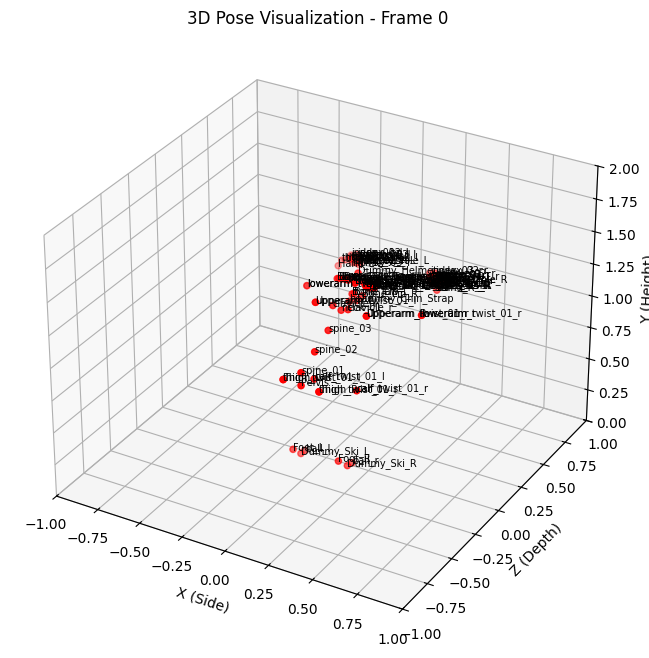

In [5]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_first_frame(json_file_path):
    # 1. データの読み込み (BOM対策を含む)
    with open(json_file_path, 'r', encoding='utf-8-sig') as f:
        # 最初の1行（frame 0）だけを読み込む
        first_line = f.readline()
        if not first_line:
            print("ファイルが空です。")
            return
        frame_data = json.loads(first_line)

    # 2. 関節データの抽出
    joints = frame_data['joints3d']
    x = [j['x'] for j in joints]
    y = [j['y'] for j in joints]
    z = [j['z'] for j in joints]
    names = [j['name'] for j in joints]

    # 3. 3Dプロットの設定
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 散布図としてプロット (MatplotlibのZ軸を「高さ」にするため、yとzを入れ替えて表示)
    ax.scatter(x, z, y, c='red', marker='o', s=20)

    # 各点に名前を表示（一部の主要な関節のみ表示させたい場合は条件分岐を追加してください）
    for i, name in enumerate(names):
        ax.text(x[i], z[i], y[i], name, fontsize=7)

    # 軸の設定
    ax.set_xlabel('X (Side)')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y (Height)')
    ax.set_title(f"3D Pose Visualization - Frame {frame_data['frame']}")

    # 表示範囲の調整（人物が中心に来るように）
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 2)

    plt.show()

# 実行
visualize_first_frame(pose_3d)

In [6]:
# mhr70和unity关节对应的最佳匹配列表
target_joint_names = [
    'head', 'neck_01', 'spine_03', 'Pelvis',
    'Upperarm_L', 'lowerarm_l', 'Hand_L',
    'Upperarm_R', 'lowerarm_r', 'Hand_R',
    'Thigh_L', 'calf_l', 'Foot_L', 'ball_l',
    'Thigh_R', 'calf_r', 'Foot_R', 'ball_r'
]

# 对应 MHR70 标准中的 ID 索引
target_mhr_ids = [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 41, 62, 69]

# MHR70 标准 ID 与你的 JSON 骨骼名称映射
# 格式: { MHR70_ID: "Your_JSON_Bone_Name" }
unity_mhr70_mapping = {
    0:  "head",           # nose -> 用 head 代替
    5:  "Upperarm_L",     # left_shoulder
    6:  "Upperarm_R",     # right_shoulder
    7:  "lowerarm_l",     # left_elbow
    8:  "lowerarm_r",     # right_elbow
    9:  "Thigh_L",        # left_hip
    10: "Thigh_R",        # right_hip
    11: "calf_l",         # left_knee
    12: "calf_r",         # right_knee
    13: "Foot_L",         # left_ankle
    14: "Foot_R",         # right_ankle
    15: "ball_l",         # left_big_toe -> 对应脚掌
    18: "ball_r",         # right_big_toe
    41: "Hand_R",         # right_wrist
    62: "Hand_L",         # left_wrist
    69: "neck_01"         # neck
}

In [7]:
# 基于图片连线逻辑的 MHR70 索引对
# 格式: (起点ID, 终点ID, 描述)
mhr70_skeleton_links = [
    # 躯干与头部
    (69, 0,  "脖子 -> 头部"),
    (69, 5,  "脖子 -> 左肩"),
    (69, 6,  "脖子 -> 右肩"),
    (5,  6,  "左肩 -> 右肩"), # 肩膀横向连线
    
    # 左半身 (左手)
    (5,  7,  "左肩 -> 左肘"),
    (7,  62, "左肘 -> 左手腕"),
    
    # 右半身 (右手)
    (6,  8,  "右肩 -> 右肘"),
    (8,  41, "右肘 -> 右手腕"),
    
    # 下半身核心 (胯部)
    (9,  10, "左胯 -> 右胯"), # 胯部横向连线
    (5, 9,  "左肩膀 -> 左胯"),
    (6, 10, "右肩膀 -> 右胯"),
    
    # 左腿
    (9,  11, "左胯 -> 左膝"),
    (11, 13, "左膝 -> 左脚踝"),
    (13, 15, "左脚踝 -> 左脚掌"),
    
    # 右腿
    (10, 12, "右胯 -> 右膝"),
    (12, 14, "右膝 -> 右脚踝"),
    (14, 18, "右脚踝 -> 右脚掌")
]

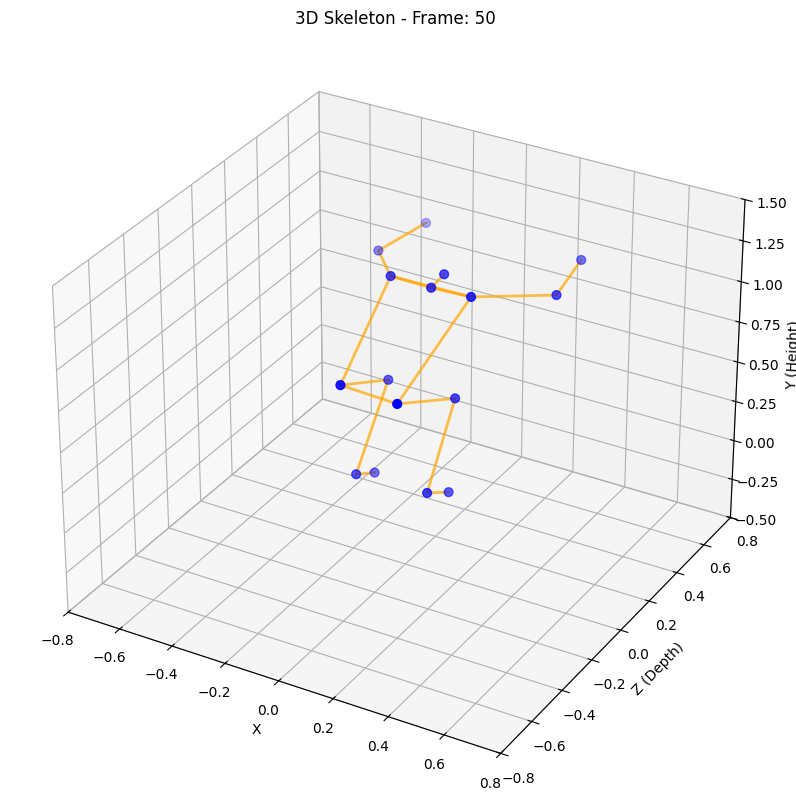

In [8]:
import json
import matplotlib.pyplot as plt

def visualize_mhr_joints_with_lines(json_file_path, target_frame=0):
    """
    json_file_path: JSONL 文件路径
    target_frame: 目标帧的索引（从 0 开始）
    """
    
    frame_data = None
    
    # 1. 数据的加载 (逐行读取，定位到目标帧)
    with open(json_file_path, 'r', encoding='utf-8-sig') as f:
        for i, line in enumerate(f):
            if i == target_frame:
                frame_data = json.loads(line)
                break
    
    if frame_data is None:
        print(f"Error: 未找到第 {target_frame} 帧数据（文件总行数可能不足）。")
        return

    # 4. 提取坐标并建立查找字典
    joints = frame_data['joints3d']
    coord_map = {j['name']: (j['x'], j['y'], j['z']) for j in joints}

    # 5. 3D 绘图初始化
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 6. 绘制连线
    for start_id, end_id, _ in mhr70_skeleton_links:
        start_bone = unity_mhr70_mapping.get(start_id)
        end_bone = unity_mhr70_mapping.get(end_id)

        if start_bone in coord_map and end_bone in coord_map:
            xs = [coord_map[start_bone][0], coord_map[end_bone][0]]
            ys = [coord_map[start_bone][1], coord_map[end_bone][1]]
            zs = [coord_map[start_bone][2], coord_map[end_bone][2]]
            
            # Matplotlib 轴映射：X -> X, Z -> Y, Y -> Z
            ax.plot(xs, zs, ys, color='orange', linewidth=2, alpha=0.7)

    # 7. 绘制关节点
    filtered_x, filtered_y, filtered_z = [], [], []
    for name in unity_mhr70_mapping.values():
        if name in coord_map:
            filtered_x.append(coord_map[name][0])
            filtered_y.append(coord_map[name][1])
            filtered_z.append(coord_map[name][2])

    ax.scatter(filtered_x, filtered_z, filtered_y, c='blue', s=40)

    # 8. 装饰
    ax.set_xlabel('X')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y (Height)')
    ax.set_title(f"3D Skeleton - Frame: {target_frame}")
    
    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.8, 0.8)
    ax.set_zlim(-0.5, 1.5) 
    
    plt.show()

# 调用：比如查看第 50 帧的数据
visualize_mhr_joints_with_lines(pose_3d, target_frame=50)

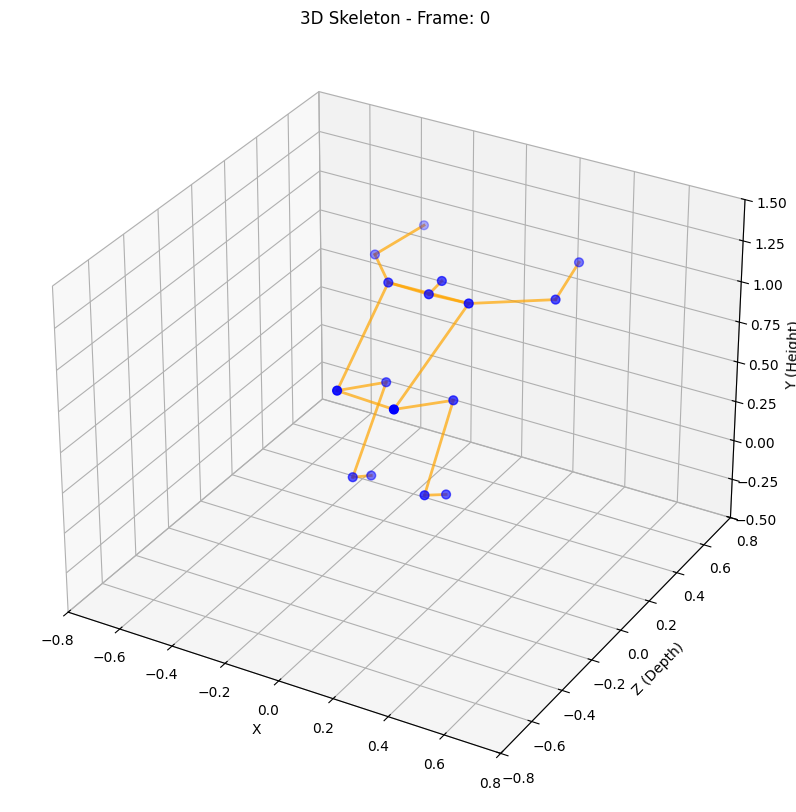

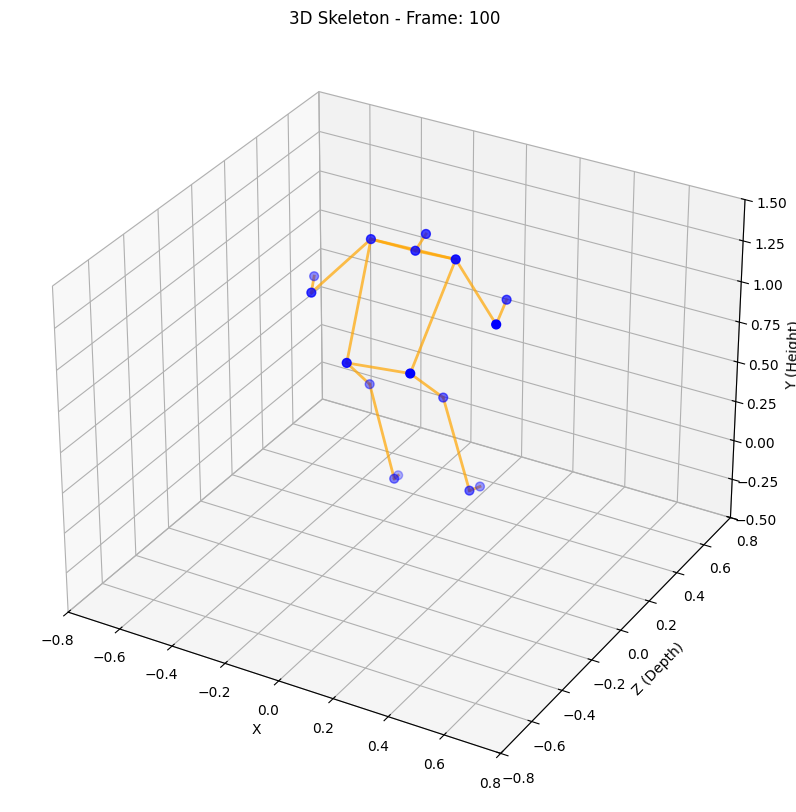

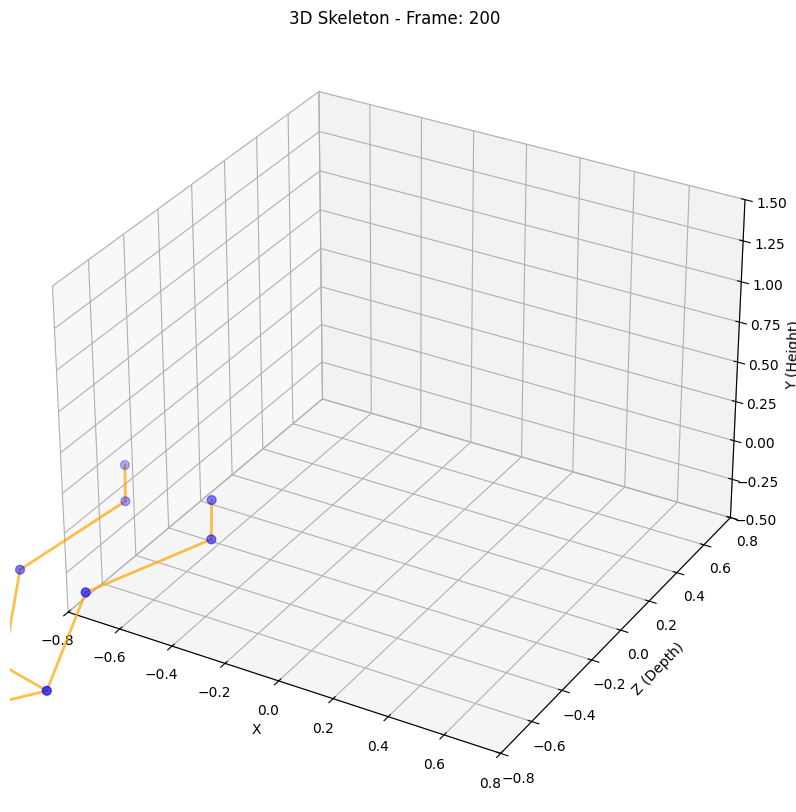

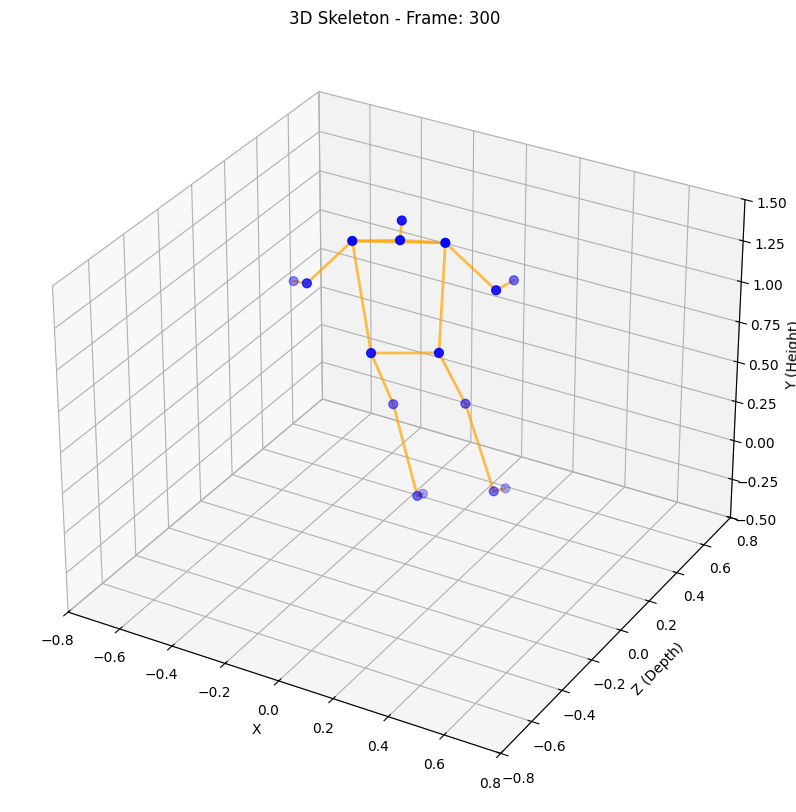

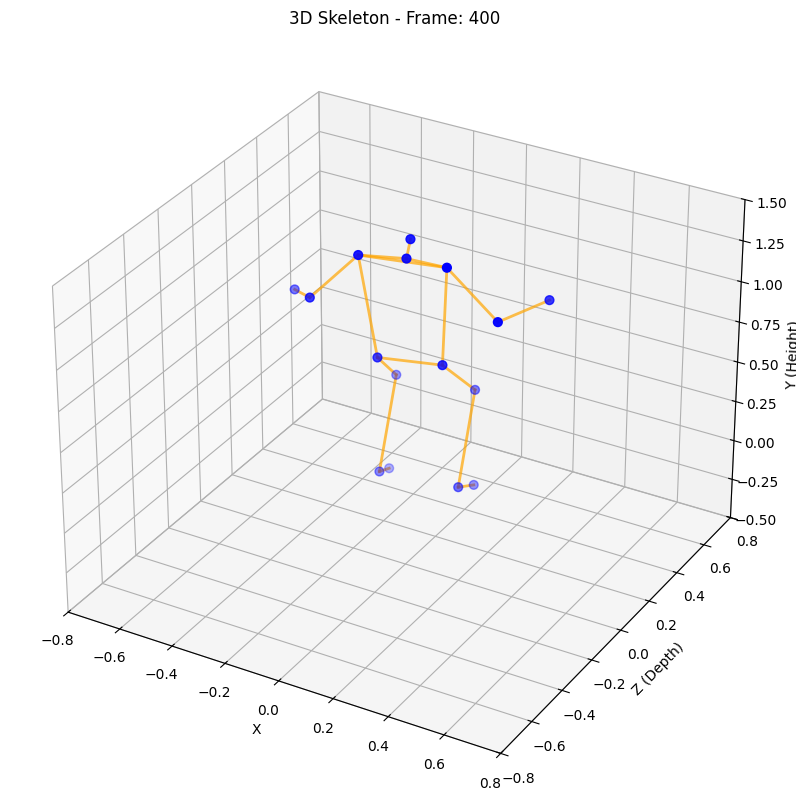

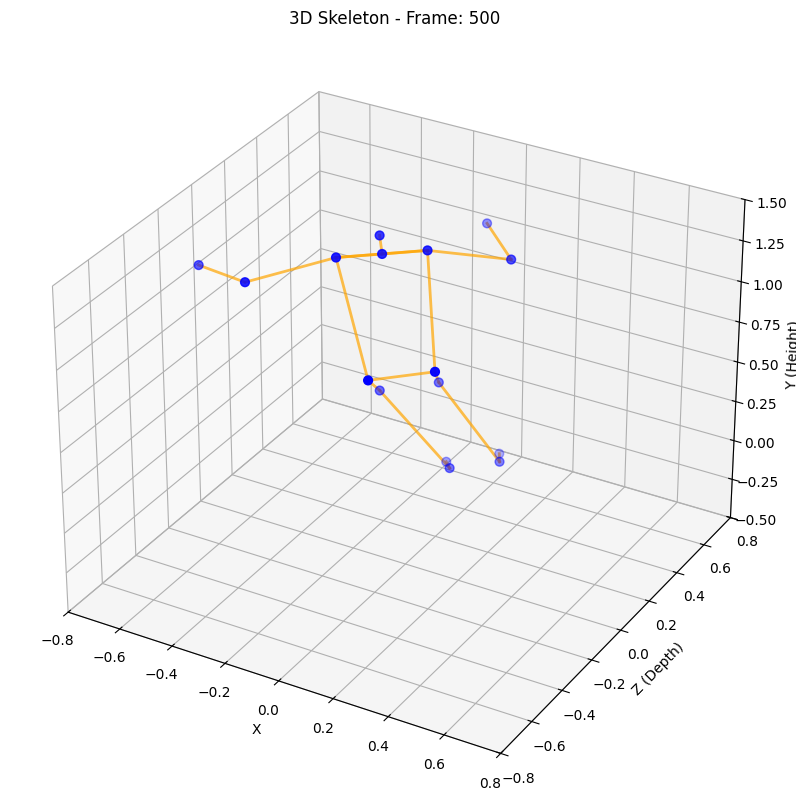

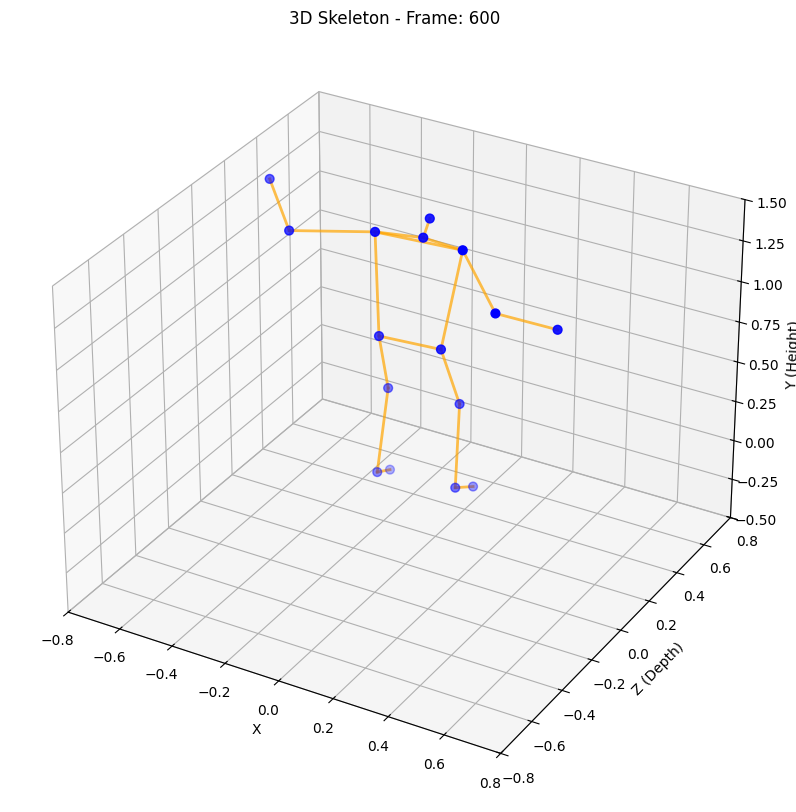

In [9]:
for i in range(0, 678, 100):
    visualize_mhr_joints_with_lines(pose_3d, target_frame=i)

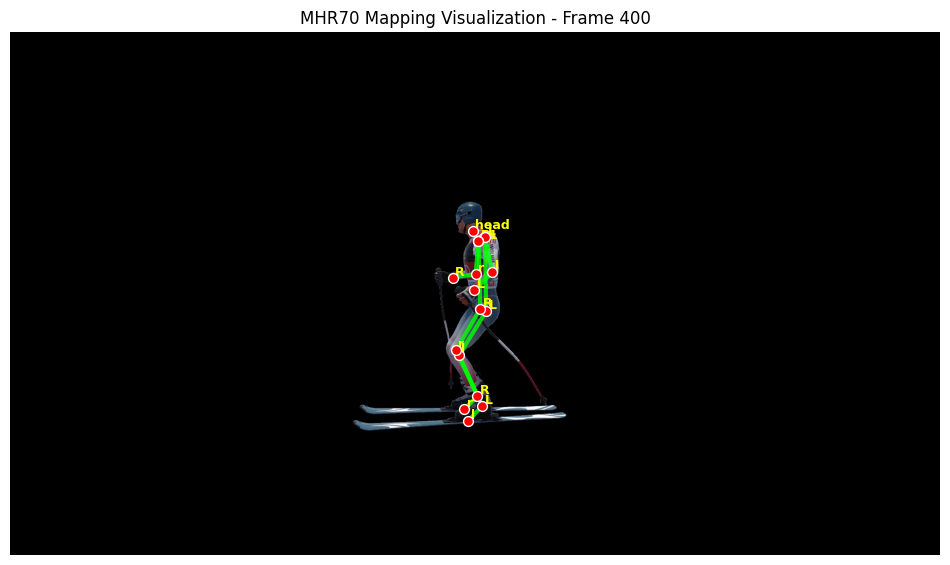

In [10]:
import json
import cv2
import matplotlib.pyplot as plt

def visualize_filtered_pose(video_path, jsonl_path, target_frame=4):
    
    target_names = set(unity_mhr70_mapping.values())

    # 1. データの読み込み
    joint_data = None
    with open(jsonl_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            data = json.loads(line)
            if data['frame_idx'] == target_frame:
                joint_data = data
                break

    if not joint_data:
        print(f"Frame {target_frame} not found.")
        return

    # 2. ビデオの読み込み
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
    ret, frame = cap.read()
    cap.release()

    if not ret: return

    v_h, v_w = frame.shape[:2]
    # 注意：如果 JSON 中没有宽向高度信息，请确保默认值正确
    d_w, d_h = joint_data.get('width', 1920), joint_data.get('height', 1080)
    scale_x, scale_y = v_w / d_w, v_h / d_h

    # 3. フィルタリングと座標変換 (建立 骨骼名 -> 像素坐标 的映射)
    name_to_pos = {}
    for j in joint_data['joints2d']:
        if j['name'] in target_names:
            u = j['u'] * scale_x
            # 注意：如果你的 2D 数据 v=0 是顶部，则不需要 v_h - ...
            # 如果可视化发现倒置了，请保留或移除这一行
            v = v_h - (j['v'] * scale_y) 
            name_to_pos[j['name']] = (u, v)

    # 4. 描画
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # 骨格（线）的描画 - 使用 ID 映射逻辑
    for start_id, end_id, _ in mhr70_skeleton_links:
        start_name = unity_mhr70_mapping.get(start_id)
        end_name = unity_mhr70_mapping.get(end_id)
        
        if start_name in name_to_pos and end_name in name_to_pos:
            p1, p2 = name_to_pos[start_name], name_to_pos[end_name]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='lime', linewidth=3, alpha=0.8)

    # 点のプロット
    for name, (u, v) in name_to_pos.items():
        plt.scatter(u, v, c='red', s=50, edgecolors='white', zorder=5)
        # 显示简短名称
        plt.text(u + 5, v - 5, name.split('_')[-1], color='yellow', fontsize=9, fontweight='bold')

    plt.title(f"MHR70 Mapping Visualization - Frame {target_frame}")
    plt.axis('off')
    plt.show()

# 执行
visualize_filtered_pose(left_video, pose_2d_left, target_frame=400)

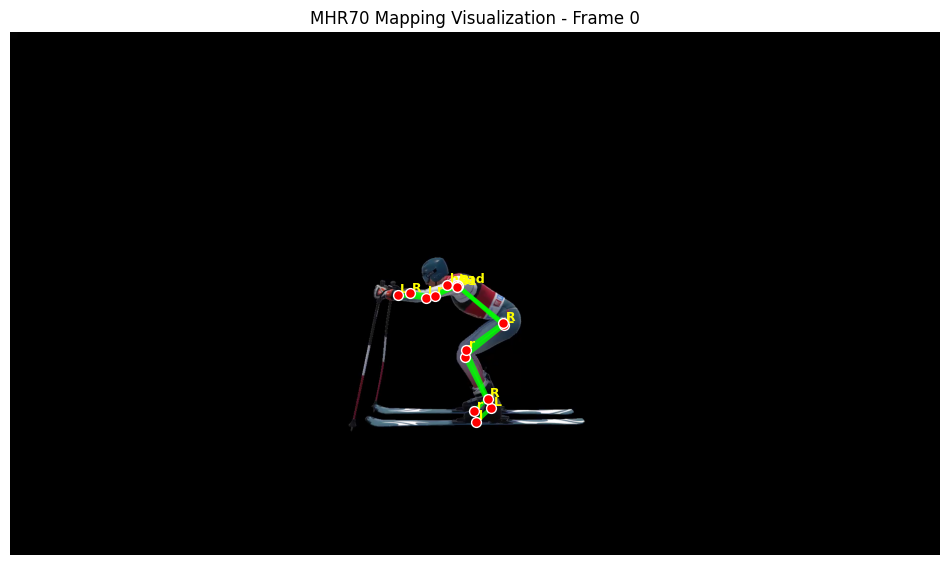

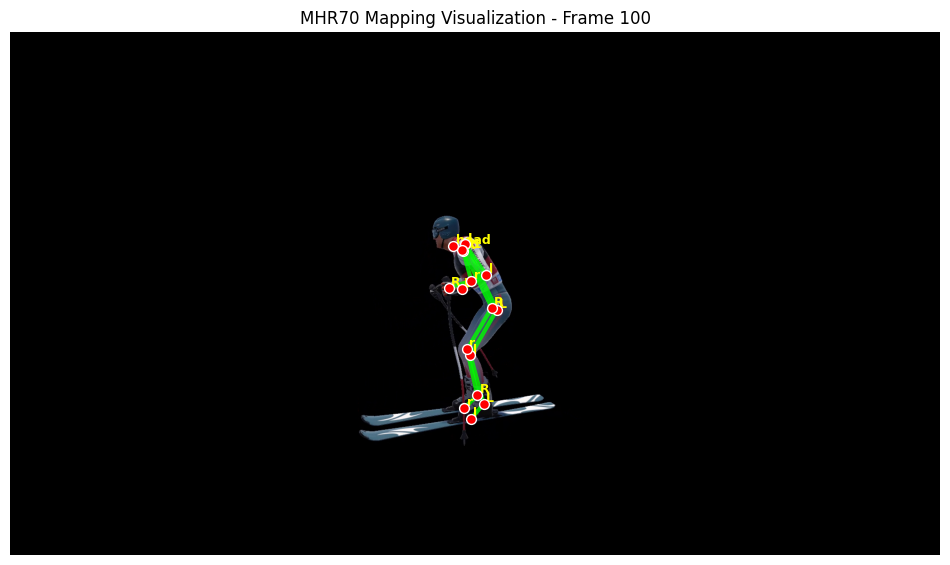

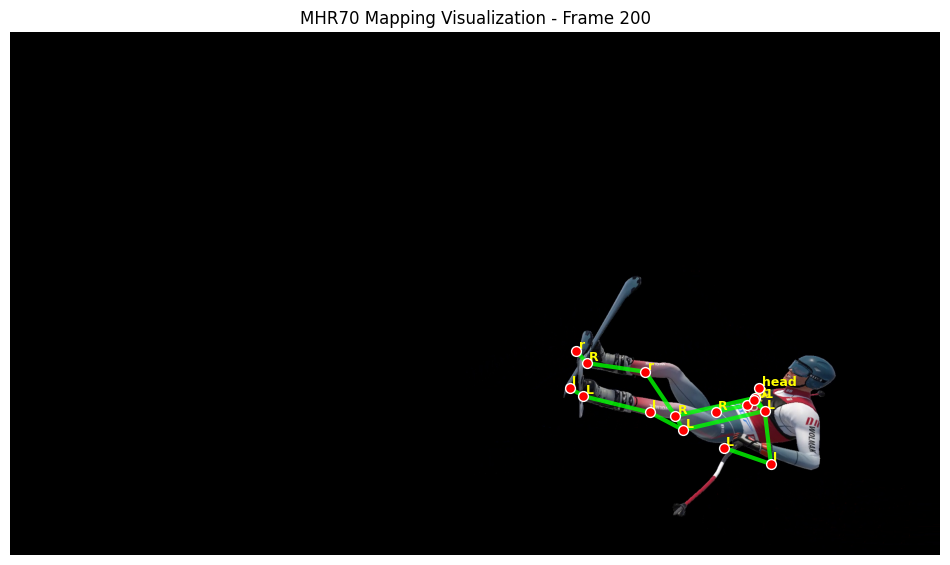

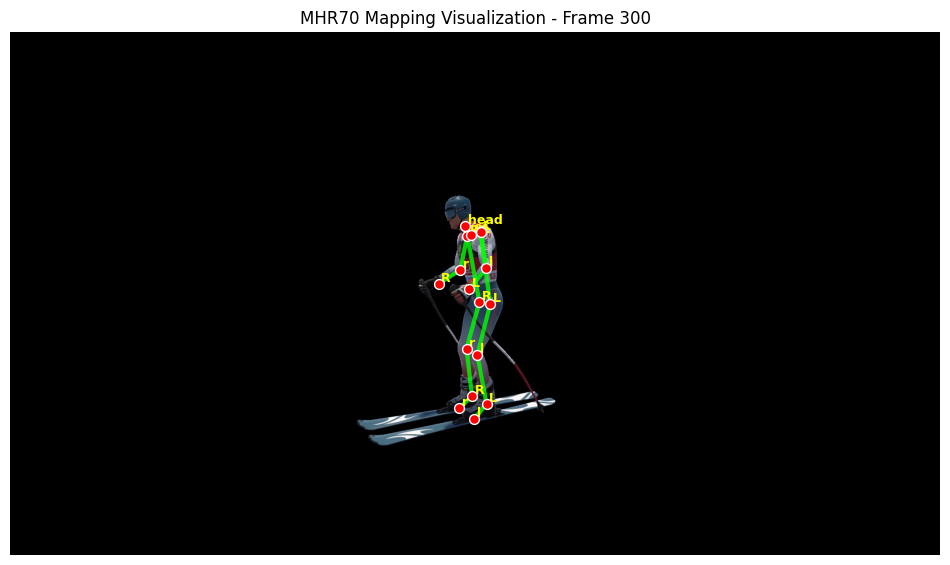

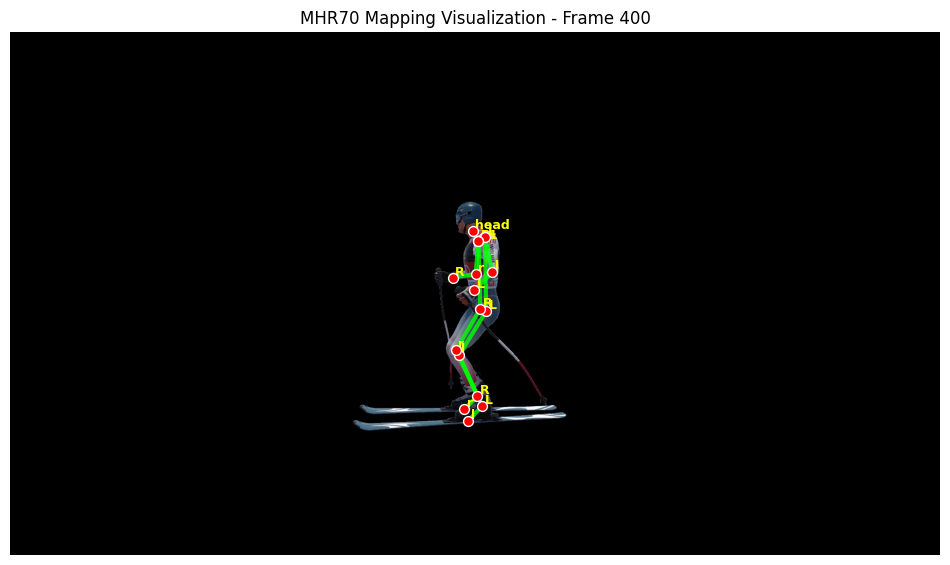

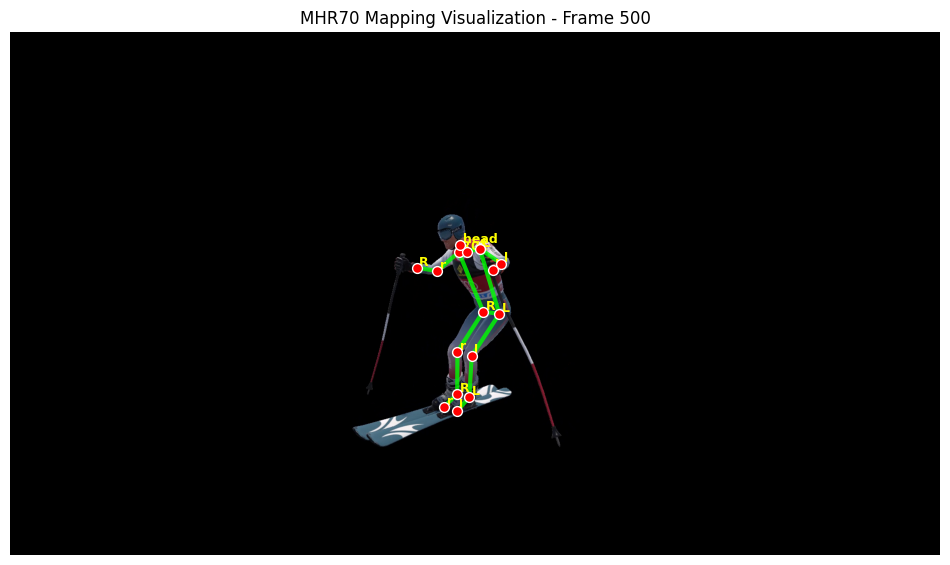

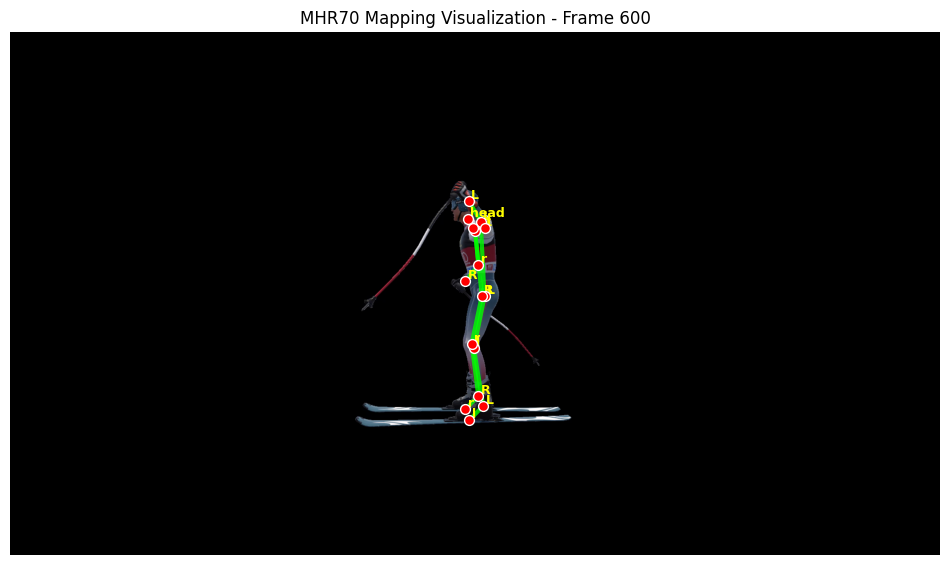

In [11]:
for i in range(0, 678, 100):
    visualize_filtered_pose(left_video, pose_2d_left, target_frame=i)

In [12]:
import json
import cv2

def check_frame_sync(video_path, jsonl_path, num_samples=5):
    # 1. ビデオの情報を取得
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("ビデオを開けませんでした。")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"--- ビデオ情報 ---")
    print(f"FPS: {fps}, 総フレーム数: {total_frames}")

    # 2. JSONLデータの読み込み
    json_data = []
    with open(jsonl_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            json_data.append(json.loads(line))
    
    json_total = len(json_data)
    print(f"JSONL総フレーム数: {json_total}")

    if abs(total_frames - json_total) > 1:
        print(f"警告: フレーム数が一致しません！ (差: {total_frames - json_total})")
    else:
        print("OK: フレーム数はほぼ一致しています。")

    # 3. サンプルフレームでの時間(time)の比較
    print(f"\n--- タイムスタンプの比較 (最初の{num_samples}フレーム) ---")
    print(f"{'Frame':<8} | {'Video Time(s)':<15} | {'JSON Time(s)':<15} | {'Diff(s)':<10}")
    
    for i in range(min(num_samples, json_total, total_frames)):
        video_time = i / fps
        json_time = json_data[i].get('time', 0.0)
        diff = abs(video_time - json_time)
        print(f"{i:<8} | {video_time:<15.4f} | {json_time:<15.4f} | {diff:<10.4f}")

    cap.release()

# 実行
check_frame_sync(left_video, pose_2d_left)

--- ビデオ情報 ---
FPS: 60.0, 総フレーム数: 677
JSONL総フレーム数: 677
OK: フレーム数はほぼ一致しています。

--- タイムスタンプの比較 (最初の5フレーム) ---
Frame    | Video Time(s)   | JSON Time(s)    | Diff(s)   
0        | 0.0000          | 0.0000          | 0.0000    
1        | 0.0167          | 0.0167          | 0.0000    
2        | 0.0333          | 0.0333          | 0.0000    
3        | 0.0500          | 0.0500          | 0.0000    
4        | 0.0667          | 0.0667          | 0.0000    
